In [2]:
import ast

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Импорт утилитарных функций для работы с данными: 
# проверка пропусков и открытие JSON файлов.
from data_utils import check_missing, open_json

sns.set()
pd.set_option('display.float_format', '{:.2f}'.format)
eng_format = ticker.EngFormatter()

# Описание задачи

**Цель проекта:** 

Спарсить данные о фильмах с сайта Кинопоиск, провести их анализ и разработать модель машинного обучения, которая будет предсказывать сборы фильма в США.

**Цель текущего ноутбука:**

- Провести краткий анализ фильмов всех персон. 
- Рассчитать интегральные метрики для каждого фильма, суммируя индивидуальные метрики актеров, режиссеров и сценаристов, участвующих в этом фильме. 
- Эти метрики будут основаны на всех работах участников до выпуска текущего фильма.


# Загрузка фильмов всех персон

**Датасет с фильмами всех персон был получен в ноутбуке "1.Парсинг" в разделе "Информация о фильмах, в которых участвовали персоны"**

In [3]:
# Загрузка фильмов всех персон
df = pd.read_csv('data/movies_all_persons.csv',
                        sep=';',
                        low_memory=False)

# Оставим фильмы и мультфильмы
df = df[df.type.isin(['movie', 'cartoon'])].copy()

cols_to_drop = [
    'художники', 'актеры дубляжа', 'монтажеры', 'продюсеры', 'операторы',
    'композиторы', 'художники_id', 'актеры дубляжа_id', 'монтажеры_id',
    'продюсеры_id', 'операторы_id', 'композиторы_id'
]

# Оставим из персон колонки режиссеров актеров и сценаристов (редакторов)
df = df.drop(cols_to_drop, axis=1)
df = df.set_index('movie_id')

# Переименуем редакторов в сценаристов для ясности
df = df.rename(columns={
    'редакторы': 'сценаристы',
    'редакторы_id': 'сценаристы_id'
})

cols_lists = [
    'genres', 'countries', 'режиссеры_id', 'сценаристы_id', 'актеры_id',
    'режиссеры', 'сценаристы', 'актеры'
]

# Заменим пустые списки в колонках на проупски
for col in cols_lists:
    df.loc[df[col] == "[]", col] = np.nan

votes = ['votes_filmCritics', 'votes_await', 'votes_imdb', 'votes_kp']
ratings = ['rating_kp', 'rating_imdb', 'rating_filmCritics']

# Нулевые рейтинги и оценки означают их отсутсвие - заменим на пропуски
for col in votes + ratings:
    df.loc[df[col] == 0, col] = np.nan

Описание полей (аналогичные полям в главной таблице с фильмами для предсказаний из ноутбука "2.EDA"):

- **movie_id** - уникальный идентификатор фильма.
- **movie_name** - название фильма.
- **year** - год выпуска фильма.
- **votes_kp, votes_imdb** - количество оценок фильма на Кинопоиске и IMDB.
- **rating_kp, rating_imdb** - рейтинги фильма на Кинопоиске и IMDB.
- **votes_filmCritics** - количество оценок кинокритиков в мире
- **rating_filmCritics** - рейтинг кинокритиков в мире
- **votes_await** - количество ожидающих фильм на Кинопоиске
- **movieLength** - длина фильма
- **ageRating, ratingMpaa** - возрастные рейтинги фильма
- **type** - тип картины (фильм/мультфильм)
- **genres** - жанры фильма
- **countries** - страны фильма
- **режиссеры, сценаристы, актеры** - имена персон, учавствующих в фильме
- **режиссеры_id, сценаристы_id, актеры_id** - id персон, учавствующих в фильме
- **fees_world, fees_usa, fees_russia** - сборы фильма в мире, США, России
- **fees_world_currency и т.д.** - валюта сборов фильма
- **budget, budget_currency** - бюджет и валюта бюджета фильма
- **videos_trailers_number** - количество трейлеров
- **videos_teasers_number** - количество тизеров

In [4]:
df[:5]

,movie_name,year,votes_kp,votes_imdb,votes_filmCritics,votes_await,rating_kp,rating_imdb,rating_filmCritics,movieLength,...,fees_world,fees_world_currency,fees_usa,fees_usa_currency,fees_russia,fees_russia_currency,budget,budget_currency,videos_trailers_number,videos_teasers_number
movie_id,,,,,,,,,,,,,,,,,,,,,
8408,Гарри Поттер и Кубок огня,2005,509399.00,649477.00,255.00,3.00,7.95,7.70,7.40,157.00,...,895921036.00,$,290013036.00,$,7837694.00,$,150000000.00,$,5.00,0.00
387556,Хатико: Самый верный друг,2008,494048.00,296214.00,28.00,516.00,8.35,8.10,5.90,89.00,...,46184345.00,$,NaN,NaN,2046840.00,$,16000000.00,$,3.00,0.00
426004,Мальчишник в Вегасе,2009,368415.00,810907.00,240.00,709.00,7.86,7.70,6.80,96.00,...,467483912.00,$,277322503.00,$,5260019.00,$,35000000.00,$,3.00,0.00
1045583,Конёк-Горбунок,2021,367624.00,1088.00,NaN,6241.00,6.95,5.70,NaN,111.00,...,15735746.00,$,NaN,NaN,15814332.00,$,760000000.00,₽,1.00,0.00
4484,Мумия,1999,322403.00,445137.00,101.00,NaN,7.81,7.10,5.90,124.00,...,415933406.00,$,155385488.00,$,NaN,NaN,80000000.00,$,2.00,0.00


## Краткий анализ

In [5]:
df.shape

(14343, 31)

In [6]:
check_missing(df)

,пропущенных_строк,процент_пропусков
countries,2,0.01%
movie_name,13,0.09%
movieLength,22,0.15%
режиссеры_id,71,0.50%
режиссеры,71,0.50%
актеры_id,90,0.63%
актеры,90,0.63%
сценаристы_id,174,1.21%
сценаристы,174,1.21%
votes_imdb,323,2.25%


1. **Минимальные пропуски (менее 1%):**
   - `countries`: страны производства фильма.
   - `movie_name`: название фильма.
   - `movieLength`: продолжительность фильма.
   - `режиссеры_id` и `режиссеры`: идентификатор и имя режиссёра фильма соответственно.
   - `актеры_id` и `актеры`: идентификаторы и имена актеров фильма соответственно.


2. **Средние пропуски (1% - 10%):**
   - `сценаристы_id` и `сценаристы`: идентификаторы и имена сценаристов фильма.
   - `votes_imdb` и `rating_imdb`: количество голосов и рейтинг фильма на IMDB соответственно.
   - `videos_teasers_number` и `videos_trailers_number`: количество тизеров и трейлеров фильма.


3. **Значительные пропуски (10% - 50%):**
   - `ageRating`: возрастное ограничение просмотра фильма.
   - `fees_world` и `fees_world_currency`: сборы фильма в мировом прокате и их валюта соответственно.
   - `votes_filmCritics` и `rating_filmCritics`: количество голосов и рейтинг фильма от кинокритиков.
   - `ratingMpaa`: рейтинг фильма по системе MPAA.


4. **Критические пропуски (более 50%):**
   - `votes_await`: количество ожидающих просмотра.
   - `budget` и `budget_currency`: бюджет фильма и его валюта соответственно.
   - `fees_usa` и `fees_usa_currency`: сборы фильма в США и их валюта.
   - `fees_russia` и `fees_russia_currency`: сборы фильма в России и их валюта.

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,14343.00,2006.16,14.62,1902.00,2001.00,2010.00,2017.00,2023.00
votes_kp,14343.00,39088.29,86557.69,2000.00,3980.00,9534.00,32310.50,1678838.00
votes_imdb,14020.00,64209.78,148811.02,7.00,3502.00,15773.50,57599.25,2798608.00
votes_filmCritics,9382.00,102.90,150.34,1.00,30.00,71.00,147.00,9299.00
votes_await,7607.00,3754.46,10083.39,1.00,65.00,499.00,2496.50,225677.00
rating_kp,14343.00,6.66,0.99,1.04,6.12,6.77,7.34,9.34
rating_imdb,14020.00,6.31,1.09,1.00,5.70,6.40,7.10,9.60
rating_filmCritics,9381.00,5.99,1.47,1.50,4.90,6.00,7.10,10.00
movieLength,14321.00,102.35,25.41,2.00,90.00,100.00,113.00,583.00
ageRating,12886.00,14.45,4.58,0.00,12.00,16.00,18.00,18.00


1. **Год выпуска (year)**
   - Фильмы в датасете охватывают период с 1902 года по 2023 год.
   - Средний год выпуска фильма – 2006, что показывает, что большинство фильмов в датасете относятся к более новому времени.
   
   
2. **Голоса и рейтинги**
   - `votes_kp`, `votes_imdb`, `votes_filmCritics`, и `votes_await` представляют количество голосов на разных платформах. Из всех платформ, IMDB имеет наибольшее среднее количество голосов (~64,209).
   - Рейтинги (`rating_kp`, `rating_imdb`, `rating_filmCritics`) в среднем варьируются от ~6 до 7 баллов из 10.
   - Рейтинги критиков (`rating_filmCritics`) немного ниже, в среднем около 6 баллов.


3. **Длительность фильма (movieLength)**
   - Фильмы в датасете варьируются от очень коротких (2 минуты) до очень длинных (583 минуты или ~9,7 часа).
   - Средняя длительность фильма составляет 102 минуты.


4. **Возрастной рейтинг (ageRating)**
   - В среднем фильмы имеют возрастной рейтинг в 14 лет, максимальный рейтинг – 18 лет.


5. **Сборы**
   - `fees_world`, `fees_usa`, и `fees_russia` представляют сборы фильмов в разных регионах. В среднем, сборы в мире (62,9 млн) значительно превышают сборы в США (38,7 млн) и России (2,6 млн).
   
   
6. **Бюджет (budget)**
   - Средний бюджет фильма составляет ~127,3 млн.
   - Однако, максимальное значение бюджета аномально высоко (623,3 млрд), что может указывать на ошибку в данных или на то, что в эта сумма представлена в редкой валюте.
   
   
7. **Количество трейлеров и тизеров**
   - В среднем у фильма есть 1-2 трейлера (`videos_trailers_number`) и очень мало тизеров (`videos_teasers_number`), многие из которых имеют 0 тизеров.

In [8]:
df.describe(include='object').T

,count,unique,top,freq
movie_name,14330,13408,Одержимость,7
ratingMpaa,8619,5,r,4605
type,14343,2,movie,13267
genres,14343,2504,['драма'],769
countries,14341,1693,['США'],5277
актеры,14253,14241,['Джордж Карлин'],5
режиссеры,14272,6826,['Вуди Аллен'],45
сценаристы,14169,12140,['Вуди Аллен'],38
актеры_id,14253,14241,[30943],5
режиссеры_id,14272,6851,[5890],45


1. **movie_name**:
    - 14330 записей.
    - 13408 уникальных названий фильмов.
    - Фильм "Одержимость" встречается чаще всего (7 раз).


2. **ratingMpaa**:
    - 8619 записей.
    - 5 уникальных рейтингов MPAA.
    - Наиболее частый рейтинг – "R", встречается 4605 раз.

3. **type**:
    - 14343 записи.
    - Два уникальных типа: "movie" и еще один неуказанный.
    - "movie" встречается 13267 раз.


4. **genres**:
    - 14343 записей.
    - 2504 уникальных комбинаций жанров.
    - Жанр "драма" встречается чаще всего (769 раз).


5. **countries**:
    - 14341 запись.
    - 1693 уникальных комбинаций стран.
    - Наиболее частая страна – "США" (5277 раз).


6. **актеры** (actors):
    - 14253 записи.
    - 14241 уникальных комбинаций актеров.
    - Актер "Джордж Карлин" упоминается чаще всего (5 раз).

7. **режиссеры** (directors):
    - 14272 записи.
    - 6826 уникальных режиссеров.
    - Режиссер "Вуди Аллен" упоминается чаще всего (45 раз).


8. **сценаристы** (screenwriters):
    - 14169 записи.
    - 12140 уникальных сценаристов.
    - Сценарист "Вуди Аллен" упоминается чаще всего (38 раз).


9. **fees_world_currency, fees_usa_currency, fees_russia_currency**:
    - Эти колонки представляют валюту сборов. Все они чаще всего используют доллар ("$").


10. **budget_currency**:
    - 7414 записей.
    - 36 уникальных валют.
    - Доллар ("$") встречается чаще всего (6405 раз).

In [9]:
features = [
 'year',
 'votes_kp',
 'votes_imdb',
 'votes_filmCritics',
 'votes_await',
 'rating_kp',
 'rating_imdb',
 'rating_filmCritics',
 'movieLength',
 'ageRating',
 'fees_usa',  # Из сборов оставим США
 'videos_trailers_number'
]

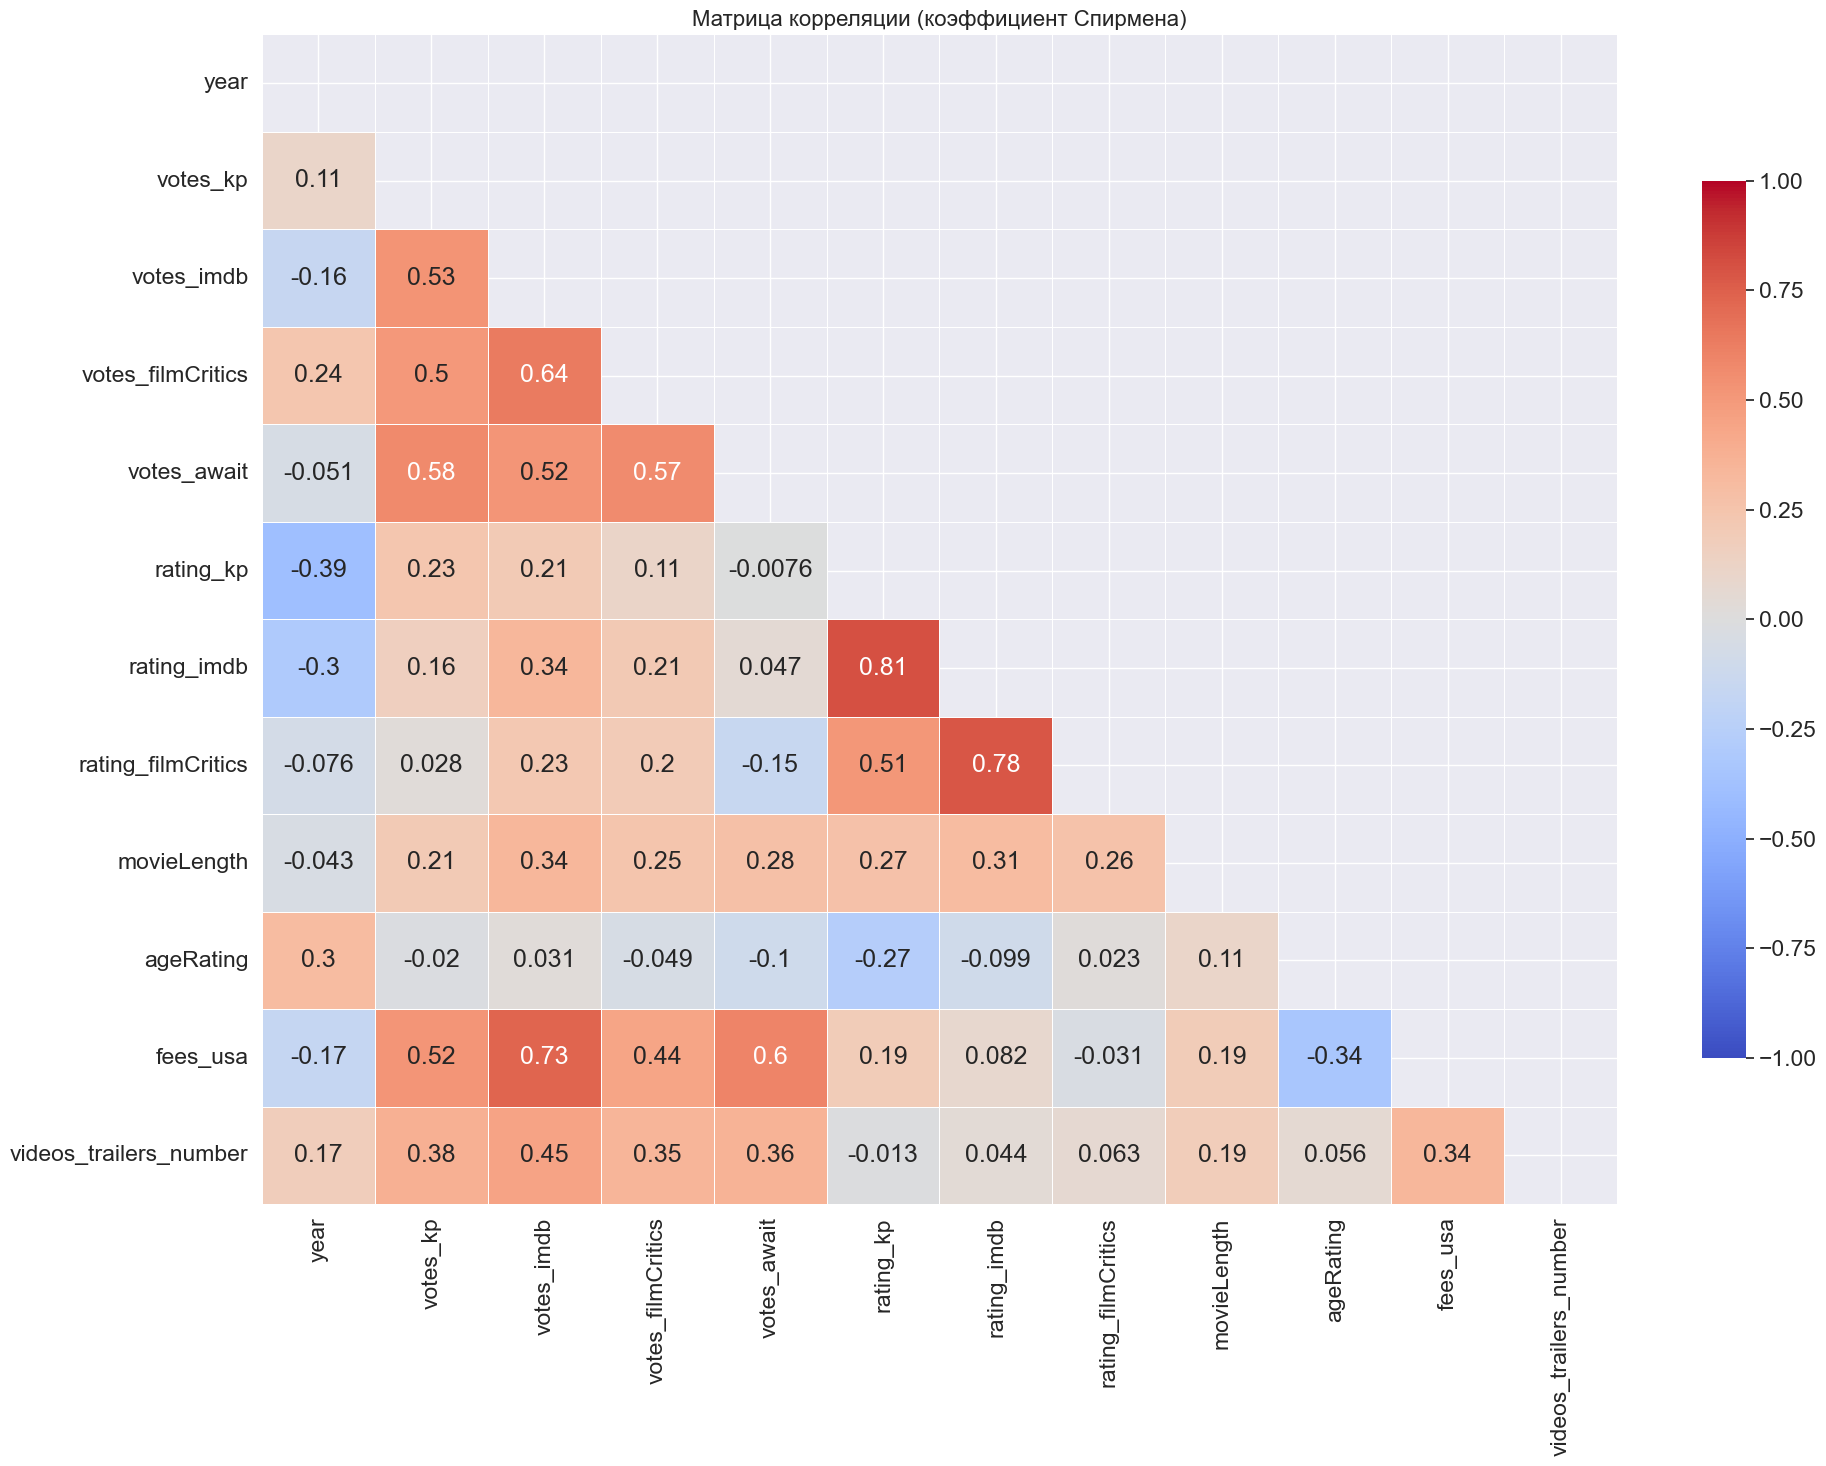

In [10]:
# Вычисляем корреляционную матрицу
corr = df[features].corr(method='spearman', numeric_only=True)

# Получаем верхний треугольник матрицы
mask = np.triu(np.ones_like(corr, dtype=bool))

# Создаем фигуру и оси
plt.figure(figsize=(20, 15))

sns.set(font_scale=1.5)  # увеличивает размер шрифта на 1.5 раза

# Создаем heatmap
sns.heatmap(
    corr, 
    annot=True,      # Аннотация значений
    mask=mask,       # Маска, чтобы показать только нижний треугольник
    cmap='coolwarm', # Цветовая палитра
    vmin=-1, vmax=1, # Минимальное и максимальное значение для масштабирования цветов
    linewidths=.5,   # Ширина линий между квадратами
    cbar_kws={"shrink": 0.75}  # Уменьшение размера цветовой шкалы
)

plt.title("Матрица корреляции (коэффициент Спирмена)", fontsize=16)
plt.tight_layout()
plt.show()

Корреляция признаков в датасете с фильмами всех персон аналогична корреляции признаков в главной таблице с фильмами для предсказаний из ноутбука "2.EDA"

Количество оценок (votes_imdb, votes_kp, votes_filmCritics) сильно коррелирует со сборами фильмов.

Так как в колонках со сборами есть довольно большое количество пропусков, то для расчета метрик персон будем использовать количество оценок фильмов, а также рейтинги фильмов и дополнительно сгенерированные признаки.

# Алгоритм расчета метрик персон

Предлагается рассчитывать метрику персон для каждого фильма следующим образом:

1. **Определить год выпуска целевого фильма (из главной таблицы для предскзаний)**


2. **<big>Найти все фильмы, в которых участвовала персона, до года выпуска целевого фильма.**


3. **Рассчитать метрику для каждого фильма из пунтка 2. по формуле:**

\begin{equation}
\large M_{movie} = V \times R \times T \times W
\end{equation}

где:
- $M_{movie}$ - метрика одного фильма персоны

- $\normalsize V$ - количество оценок фильма,

- $\normalsize R$ - рейтинг фильма,

- $\normalsize T$ - временной коэффициент,

- $\normalsize W$ - вес персоны в фильме.

4. **Суммировать метрики из пункта 3:**

\begin{equation}
\large M_{PERSON} = \sum_{i=1}^{n} M_{movie_i}
\end{equation}

где:
- $M_{PERSON}$ - итоговая метрика персоны,

- $M_{movie_i}$ - метрика i-го фильма, в котором участвовала данная персона, рассчитанная по формуле из пункта 3,

- $n$ - общее количество фильмов (до года выпуска целевого фильма), в которых участвовала данная персона.

В качестве рейтинга и количества оценок фильма, используем данные IMDb, так как они сильнее коррелируют со сборами в США:

- **votes_imdb** - количество оценок на IMDb
- **rating_imdb** - рейтинг фильма на IMDb

## Примечания к выбору данных для метрик:

1. **Сериалы:**  
    - Сериалы представляют особый интерес при расчёте метрик из-за их уникальной структуры. У сериала может быть множество сезонов и эпизодов.
    - Отсутствие конкретной информации об участии персоны в определенных сезонах или эпизодах затрудняет точное определение их вклада. Например, актёр или режиссёр мог участвовать только в одном сезоне или даже в одном эпизоде.
    - Из-за вышеуказанных сложностей было принято решение исключить сериалы из расчёта метрик.


2. **Cameo-роли в метриках актеров:**  
    - Cameo-роли обычно коротки и могут не отражать полного потенциала или вклада актёра в фильм.
    - Включение таких ролей может исказить метрику, особенно если актёр известен за свои основные роли в других произведениях.
    - Чтобы сохранить простоту и надежность метрики, cameo-роли были исключены из расчёта.

# Загрузка информации о персонах

**Датасет с информацией о персонах и фильмах, в которых они участвовали, который был получен в ноутбуке "1.Парсинг" в разделе "Информация о персонах"**

In [11]:
df_persons = pd.read_csv('data/one_person_one_movie.csv', sep=';')

In [12]:
df_persons

,person_id,person_name,age,countAwards,death,movie_id,movie_name,movie_rating,movie_profession
0,6966712,Хан Мин-ёп,33.00,NaN,NaN,4446955.00,Децибел,7.38,actor
1,6966712,Хан Мин-ёп,33.00,NaN,NaN,1100409.00,Дьявольская радость,7.34,actor
2,14363,Пол Беттани,52.00,NaN,NaN,1203040.00,Ванда/Вижн,7.46,actor
3,14363,Пол Беттани,52.00,NaN,NaN,4422313.00,Очень британский скандал,6.53,actor
4,14363,Пол Беттани,52.00,NaN,NaN,1261534.00,"Что, если...?",6.93,actor
...,...,...,...,...,...,...,...,...,...
679534,295,Наташа Лионн,44.00,NaN,NaN,587593.00,Развлечения сегодня вечером,7.16,cameo
679535,295,Наташа Лионн,44.00,NaN,NaN,400753.00,Saturday Night Live,8.35,cameo
679536,295,Наташа Лионн,44.00,NaN,NaN,667205.00,Сегодня,6.85,cameo
679537,295,Наташа Лионн,44.00,NaN,NaN,1012286.00,Семья,6.29,uncredited


**Информация о персонах и их фильмах**

- **person_id**: Уникальный идентификатор персоны.
- **person_name**: Имя персоны.
- **age**: Возраст персоны.
- **countAwards**: Количество наград, полученных персоной.
- **death**: Дата смерти персоны (если применимо).
- **movie_id**: Уникальный идентификатор фильма, в котором участвовала персона.
- **movie_name**: Название фильма.
- **movie_rating**: Рейтинг фильма (на Кинопоиске).
- **movie_profession**: Профессия персоны в данном фильме (например, актёр, режиссёр).

Данный DataFrame содержит информацию о различных персонах и фильмах, в которых они участвовали, а также детали об их профессии в этих фильмах.

In [13]:
# Оставим профессии режиссер, актер и сценарист
df_persons = df_persons[df_persons.movie_profession.isin(
    ['actor', 'director', 'writer'])]

# Не будем использовать информацию о возрасте, смерти и наградах
# колонку movie_name удаляем, чтобы она не дублировалась при последующем слиянии таблиц
df_persons = df_persons.drop(columns=['age', 'countAwards', 'death', 'movie_name'])

## Создание полной таблицы для расчета метрик

In [14]:
# Присоединим подробную информацию о фильмах персон
df = df_persons.merge(df.reset_index(), on='movie_id', how='inner')

# Оставим колонки, которые будем использовать для расчета метрик
cols = [
    'person_name',  # имя персоны оставляем для наглядности
    'movie_name',  # имя фильма тоже оставим для наглядности
    'person_id',
    'movie_id',
    'movie_profession',
    'year',
    'актеры_id',
    'режиссеры_id',
    'сценаристы_id',
    # Для предскзания сборов в США используем оценки и рейтинги IMDb,
    # так как они сильнее корелируют со сборами в США
    'votes_imdb',
    'rating_imdb',
#     'votes_kp',
#     'rating_kp'
]

df = df[cols]

df[8:15]

,person_name,movie_name,person_id,movie_id,movie_profession,year,актеры_id,режиссеры_id,сценаристы_id,votes_imdb,rating_imdb
8,Ли Джон-сок,Децибел,2797801,4446955.00,actor,2022,"[493908, 2797801, 482298, 1890897, 3900254, 56...",[1041095],NaN,1306.00,6.20
9,Чха Ын-у,Децибел,4733565,4446955.00,actor,2022,"[493908, 2797801, 482298, 1890897, 3900254, 56...",[1041095],NaN,1306.00,6.20
10,Ли Сан-хи,Децибел,3900254,4446955.00,actor,2022,"[493908, 2797801, 482298, 1890897, 3900254, 56...",[1041095],NaN,1306.00,6.20
11,Пол Беттани,Мстители: Война бесконечности,14363,843649.00,actor,2018,"[10096, 1300401, 10467, 49627, 3903, 6795, 345...","[40181, 40182]","[477114, 477115, 8242, 29954]",1157562.00,8.40
12,Роберт Дауни мл.,Мстители: Война бесконечности,10096,843649.00,actor,2018,"[10096, 1300401, 10467, 49627, 3903, 6795, 345...","[40181, 40182]","[477114, 477115, 8242, 29954]",1157562.00,8.40
13,Карен Гиллан,Мстители: Война бесконечности,1235107,843649.00,actor,2018,"[10096, 1300401, 10467, 49627, 3903, 6795, 345...","[40181, 40182]","[477114, 477115, 8242, 29954]",1157562.00,8.40
14,Джош Бролин,Мстители: Война бесконечности,14668,843649.00,actor,2018,"[10096, 1300401, 10467, 49627, 3903, 6795, 345...","[40181, 40182]","[477114, 477115, 8242, 29954]",1157562.00,8.40


In [15]:
df.shape

(148928, 11)

Полученный датасет предоставляет полную картину того, кто работал над каким фильмом, а также необходимую информацию о самом фильме. 

Теперь, например, мы можем легко узнать, какие фильмы снял определенный режиссер, какое было количество оценок у этих фильмов и какие они получили рейтинги. Аналогичную информацию сможем получить о каждом актере и сценаристе.

# Подготовка данных для рассчета метрик

In [18]:
# Заполним пропуски в колонках imdb
# Отсутствующие оценки и рейтинги заполним нулем
for col in ['votes_imdb', 'rating_imdb']:
    df[col] = df[col].fillna(0)

## Временной коэффициент

В метрику будет включаться экспоненциальный временной коэффициент для учета старения фильмов, что позволит уделять больше внимания новым фильмам по сравнению со старыми.

In [19]:
# Возраст фильма
# Создадим два признака для анализа выборки с и без включения данных 2020-2023 годов
df['movie_age_2019'] = 2019 - df.year
df['movie_age_2023'] = 2023 - df.year

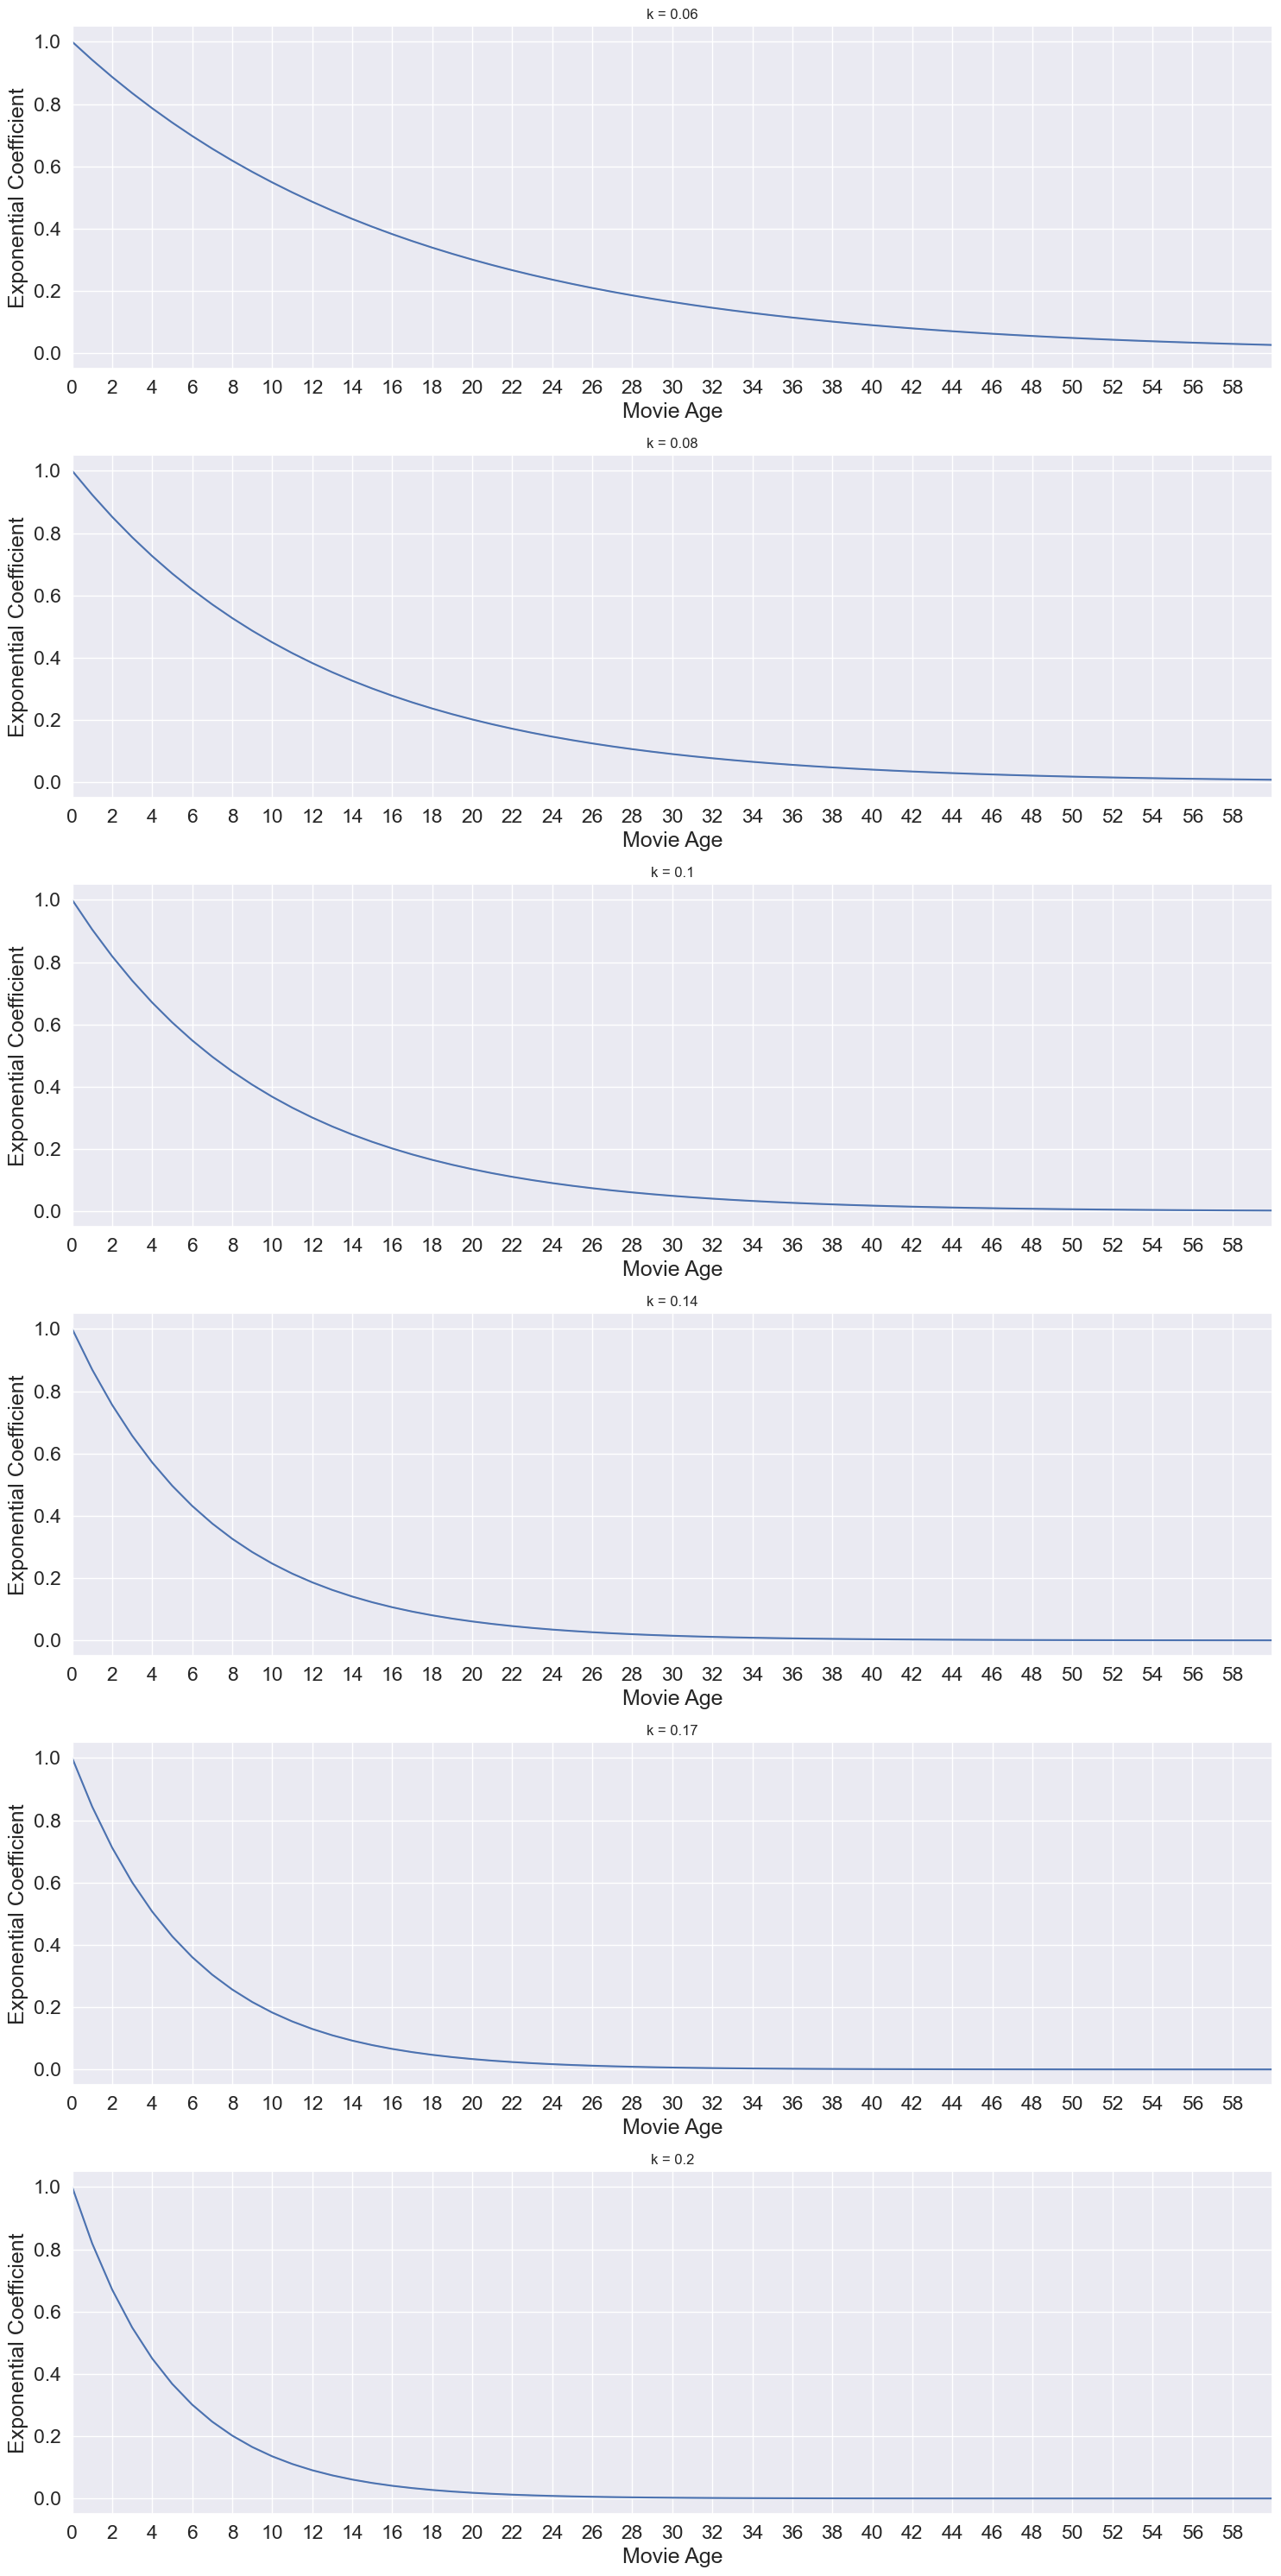

In [20]:
# Тестирование временного коэффициента
df_temp =  df[['year', 'movie_age_2023']].copy()

# Список значений для коэффициента k
k_values = [0.06, 0.08, 0.1, 0.14, 0.17, 0.2]

fig, axes = plt.subplots(nrows=len(k_values), figsize=(15, 30))

sns.set(font_scale=1)  # размер шрифта

# Пройтись по каждому значению k и построить график на соответствующем месте в сетке
for i, k in enumerate(k_values):
    row = i 
    ax = axes[row]
    
    df_temp[f'exp_coeff_{k}'] = np.exp(-k * df_temp['movie_age_2023'])
    sns.lineplot(data=df_temp, x='movie_age_2023', y=f'exp_coeff_{k}', ax=ax)
    ax.set_title(f'k = {k}')
    ax.set_xlabel('Movie Age')
    ax.set_ylabel('Exponential Coefficient')
    ax.set_xticks([i for i in range(0, 60, 2)])
    ax.set_xlim(0, 60)
    
plt.tight_layout()
plt.show()

In [21]:
# Возьмем временной коэффициент с k=0.1
# Для тестирования сделаем два коэффициента для разных периодов времени
# exp_coeff_2019 - для данных без включения 2020-2023 годов
# exp_coeff_2023 - для данных, включающих 2020-2023 годы

k = 0.1
df[f'exp_coeff_2019'] = np.exp(-k * df['movie_age_2019'])
df[f'exp_coeff_2023'] = np.exp(-k * df['movie_age_2023'])

In [22]:
# Преобразуем колонки в тип список для дальнейшей работы
for col in [ 'актеры_id', 'режиссеры_id', 'сценаристы_id']:
    df[col] = df[col].fillna('[]')
    df[col] = df[col].apply(lambda x: x
                            if isinstance(x, list) else ast.literal_eval(x))

**Загрузка сохраненных id персон, разделенных по профессиям в ноутбуке "1.Парсинг"**
<br>Это необходимо для того, чтобы разделить метрики на персон 3-х профессий.
<br>Так как одна и та же персона может иметь профессию как актер, так и режиссер и сценарист в разных фильмах

In [23]:
# Режиссеры
ids_directors = open_json('data_json/ids_directors.json')
ids_directors = list(map(int, ids_directors))  # перевод в тип int

# Актры
ids_actors = open_json('data_json/ids_actors.json')
ids_actors = list(map(int, ids_actors))

# Сценаристы
ids_editors = open_json('data_json/ids_editors.json')
ids_editors = list(map(int, ids_editors))

## Веса актеров

In [24]:
# Отфильтровываем датасет, чтобы оставить только актёров из списка ids_actors
df_actors = df[(df['person_id'].isin(ids_actors)) &
               (df['movie_profession'] == 'actor')].copy()

# Обрезаем список актеров до первых 10, так как на странице Кинопоиска
# обычно отображаются первые 10 актеров, и их порядок соответствует
# важности их роли в фильме.
df_actors['актеры_id'] = df_actors['актеры_id'].apply(lambda x: x[:10])


def get_role_index(row):
    """
    Функция для получения индекса актера в списке актеров фильма.
    Если актер есть в списке, 
    то функция возвращает его позицию + 1 (так как индексация начинается с 0).
    Если актера нет в списке, возвращается -1.
    """
    if row['person_id'] in row['актеры_id']:
        return row['актеры_id'].index(row['person_id']) + 1
    return -1


# Применяем функцию для каждой строки в df_actors,
# чтобы узнать позицию актера в списке актеров фильма.
df_actors['role_index'] = df_actors.apply(get_role_index, axis=1)

# Отфильтровываем данные, оставляя только те строки,
# где актер находится в списке первых 10 актеров фильма.
df_actors = df_actors[(df_actors.role_index >= 1) &
                      (df_actors.role_index <= 10)]

In [25]:
# Создаем словарь для сопоставления индекса роли актера и его веса.
# Индекс роли 1 означает, что актер занимал самую важную роль в фильме и получает максимальный вес 1.0.
# Индекс роли 10, соответственно, наименее важный из первых 10 актеров и получает минимальный вес 0.1.
# Веса убывают на 0.1 с каждым увеличением индекса роли.
map_dict = {
    1: 1.0,
    2: 0.9,
    3: 0.8,
    4: 0.7,
    5: 0.6,
    6: 0.5,
    7: 0.4,
    8: 0.3,
    9: 0.2,
    10: 0.1
}

# Применяем созданный словарь к колонке с индексами ролей, чтобы получить вес каждой роли.
# Например, если актер занимал вторую по важности роль в фильме, его вес в этом фильме будет равен 0.9.
df_actors['role_weight'] = df_actors.role_index.map(map_dict)

In [26]:
df_actors[:5].T

,0,1,2,3,4
person_name,Хан Мин-ёп,Чо Даль-хван,Ким Рэ-вон,Ли Мин-ги,У Джи-хён
movie_name,Децибел,Децибел,Децибел,Децибел,Децибел
person_id,6966712,564917,493908,1900753,3710679
movie_id,4446955.00,4446955.00,4446955.00,4446955.00,4446955.00
movie_profession,actor,actor,actor,actor,actor
year,2022,2022,2022,2022,2022
актеры_id,"[493908, 2797801, 482298, 1890897, 3900254, 56...","[493908, 2797801, 482298, 1890897, 3900254, 56...","[493908, 2797801, 482298, 1890897, 3900254, 56...","[493908, 2797801, 482298, 1890897, 3900254, 56...","[493908, 2797801, 482298, 1890897, 3900254, 56..."
режиссеры_id,[1041095],[1041095],[1041095],[1041095],[1041095]
сценаристы_id,[],[],[],[],[]
votes_imdb,1306.00,1306.00,1306.00,1306.00,1306.00


In [27]:
df_actors.shape

(77147, 17)

In [28]:
df_actors.to_csv('data/df_actors.csv', sep=';', index=False)

## Веса режиссеров

In [29]:
# Отфильтровываем датасет, чтобы оставить только режиссеров из списка ids_directors
df_directors = df[(df['person_id'].isin(ids_directors)) &
                  (df['movie_profession'] == 'director')].copy()

In [30]:
# Добавляем новую колонку, которая будет содержать количество режиссеров для каждого фильма.
# Это нужно, чтобы понять, сколько режиссеров участвовало в создании каждого фильма.
df_directors['directors_count'] = df_directors['режиссеры_id'].apply(lambda x: len(x))

# Оставляем только те фильмы, где есть хотя бы один режиссер (исключаем фильмы без режиссеров).
df_directors = df_directors[df_directors.directors_count > 0].copy()

# Если в фильме участвует несколько режиссеров, каждому из них присваивается равный вес.
# Например, если в фильме два режиссера, каждому из них будет присвоен вес 0.5.
# Если один режиссер, то ему присваивается вес 1.
df_directors['director_weight'] = df_directors['режиссеры_id'].apply(lambda x: 1 / len(x))

In [31]:
df_directors[:5].T

,7,29,56,89,103
person_name,Хван Ин-хо,Джо Руссо,Энтони Руссо,Рон Ховард,Сол Дибб
movie_name,Децибел,Мстители: Война бесконечности,Мстители: Война бесконечности,Хан Соло: Звёздные войны. Истории,Последняя битва
person_id,1041095,40182,40181,8919,695486
movie_id,4446955.00,843649.00,843649.00,841277.00,1002570.00
movie_profession,director,director,director,director,director
year,2022,2018,2018,2018,2017
актеры_id,"[493908, 2797801, 482298, 1890897, 3900254, 56...","[10096, 1300401, 10467, 49627, 3903, 6795, 345...","[10096, 1300401, 10467, 49627, 3903, 6795, 345...","[1217737, 4270654, 9839, 1830611, 1187065, 559...","[1829631, 1268067, 14363, 223, 14435, 74775, 4..."
режиссеры_id,[1041095],"[40181, 40182]","[40181, 40182]",[8919],[695486]
сценаристы_id,[],"[477114, 477115, 8242, 29954]","[477114, 477115, 8242, 29954]","[101867, 26537, 24284]","[1341792, 208326, 4926395]"
votes_imdb,1306.00,1157562.00,1157562.00,368161.00,10715.00


In [32]:
df_directors.shape

(8133, 17)

In [33]:
df_directors.to_csv('data/df_directors.csv', sep=';', index=False)

## Веса сценаристов

In [34]:
# Отфильтровываем датасет, чтобы оставить только сценаристов из списка ids_editors
df_writers = df[(df['person_id'].isin(ids_editors)) &
                (df['movie_profession'] == 'writer')].copy()

In [35]:
# Добавляем новую колонку, которая будет содержать количество сценаристов для каждого фильма.
# Это поможет нам понять, сколько сценаристов участвовало в создании каждого фильма.
df_writers['writers_count'] = df_writers['сценаристы_id'].apply(
    lambda x: len(x))

# Оставляем только те фильмы, где есть хотя бы один сценарист (исключаем фильмы без сценаристов).
df_writers = df_writers[df_writers.writers_count > 0].copy()

# Рассчитываем долю каждого сценариста в случае, если у фильма их несколько.
# Например, если у фильма два сценариста, каждому из них будет присвоен процент 0.5.
df_writers['writers_percent'] = df_writers['сценаристы_id'].apply(
    lambda x: 1 / len(x))

# Функция для определения места сценариста в списке.
# Это поможет понять важность каждого сценариста для конкретного фильма.
def get_role_index(row):
    if row['person_id'] in row['сценаристы_id']:
        return row['сценаристы_id'].index(row['person_id']) + 1
    return -1


# Применяем функцию к датафрейму, чтобы определить индекс каждого сценариста.
df_writers['writer_index'] = df_writers.apply(get_role_index, axis=1)

# Оставляем только те записи, где сценарист находится в списке (с положительным индексом).
df_writers = df_writers[df_writers.writer_index >= 1]

# Присваиваем вес каждому сценаристу в зависимости от его места в списке.
# Чем выше сценарист в списке, тем больше его вес.
df_writers['writer_weight'] = (1 / df_writers['writers_count']) * (
    df_writers['writers_count'] - df_writers['writer_index'] + 1)

In [36]:
df_writers[:5].T

,17,19,40,64,67
person_name,Джек Кёрби,Кристофер Маркус,Стивен МакФили,Стэн Ли,Джордж Лукас
movie_name,Мстители: Война бесконечности,Мстители: Война бесконечности,Мстители: Война бесконечности,Мстители: Война бесконечности,Хан Соло: Звёздные войны. Истории
person_id,29954,477114,477115,8242,24284
movie_id,843649.00,843649.00,843649.00,843649.00,841277.00
movie_profession,writer,writer,writer,writer,writer
year,2018,2018,2018,2018,2018
актеры_id,"[10096, 1300401, 10467, 49627, 3903, 6795, 345...","[10096, 1300401, 10467, 49627, 3903, 6795, 345...","[10096, 1300401, 10467, 49627, 3903, 6795, 345...","[10096, 1300401, 10467, 49627, 3903, 6795, 345...","[1217737, 4270654, 9839, 1830611, 1187065, 559..."
режиссеры_id,"[40181, 40182]","[40181, 40182]","[40181, 40182]","[40181, 40182]",[8919]
сценаристы_id,"[477114, 477115, 8242, 29954]","[477114, 477115, 8242, 29954]","[477114, 477115, 8242, 29954]","[477114, 477115, 8242, 29954]","[101867, 26537, 24284]"
votes_imdb,1157562.00,1157562.00,1157562.00,1157562.00,368161.00


In [37]:
df_writers.shape

(13642, 19)

In [38]:
df_writers.to_csv('data/df_writers.csv', sep=';', index=False)

# Расчет метрик персон

In [39]:
def person_metric(person_id, release_year, df_metrics, person_weight, exp_coeff):
    """Метрика отфильтрованных фильмов одной персоны"""

    # Фильтруем df_metrics
    # df_metrics - датасет с информацией об актерах/режиссерах/сценристах

    # Оставляем фильмы персоны до релиза рассматриваемого фильма
    filtered_df = df_metrics[(df_metrics['person_id'] == person_id)
                             & (df_metrics['year'] < release_year)]

    # Рассчитываем метрику всех отфильтрованных фильмов персоны
    # как сумму метрик всех фильмов (метрика одного фильма M = V*R*T*W)
    metric = (filtered_df['votes_imdb'] *
              filtered_df['rating_imdb'] *
              filtered_df[exp_coeff] *
              filtered_df[person_weight]
              ).sum()

    return metric


def calculate_movie_metric(persons_list, year, df_metrics, person_weight, exp_coeff):
    """Метрика всех персон из списка актеров/режисеров/сценаристов целевого фильма.
        Рассчитывается на основании фильмов до текущего релиза."""

    total_metric = 0

    # Суммируем метрики всех персон из списка id
    for person_id in persons_list:
        total_metric += person_metric(person_id,
                                      year, df_metrics, person_weight, exp_coeff)
    return total_metric

In [40]:
# Загрузка основной таблицы с фильмами для предсказаний
df_main_movies = pd.read_csv('data/movies_main_modified.csv', sep=';')

# Преобразуем колонки в тип список для дальнейшей работы
for col in ['актеры_id', 'режиссеры_id', 'сценаристы_id']:
    df_main_movies[col] = df_main_movies[col].fillna('[]')
    df_main_movies[col] = df_main_movies[col].apply(lambda x: x
                            if isinstance(x, list) else ast.literal_eval(x))
    
print(df_main_movies.shape)
    
df_main_movies[:5]

(5329, 30)


,movie_id,movie_name,year,votes_kp,votes_imdb,votes_filmCritics,votes_await,rating_kp,rating_imdb,rating_filmCritics,...,сценаристы_id,актеры_id,fees_world,fees_usa,fees_russia,budget,videos_trailers_number,Производство,Спецэффекты,budget_in_usd
0,535341,1+1,2011,1678838.00,895482.00,130.00,15.00,8.81,8.50,6.80,...,"[382906, 426346, 3152842]","[71427, 41644, 57174, 868557, 541041, 445, 964...",426588510,10198820,1725813.00,9500000.00,2.00,"['TF1 Films Production', 'TF1', 'Ten Films', '...",[],13205000.00
1,1143242,Джентльмены,2019,1524128.00,372380.00,277.00,13642.00,8.56,7.80,6.50,...,"[45159, 4984694, 1910756, 1266524]","[797, 38702, 4950097, 8090, 1067193, 1146480, ...",115171795,36471795,18003343.00,22000000.00,4.00,"['Toff Guy Films', 'STX Films', 'Miramax Films']",['Union Visual Effects'],22000000.00
2,1318972,Гнев человеческий,2021,1154017.00,197022.00,256.00,23490.00,7.61,7.10,6.30,...,"[257353, 457138, 45159, 4984694]","[1514, 8151, 12764, 206, 1638, 87456, 886617, ...",103966489,27466489,13318455.00,40000000.00,3.00,"['Flic Films UK', 'CAA Media Finance', 'Toff G...",['4-Ward Productions'],40000000.00
3,462682,Волк с Уолл-стрит,2013,1125382.00,1471424.00,289.00,43024.00,7.98,8.20,7.80,...,"[226920, 88348]","[37859, 581340, 1682023, 28949, 5899, 32376, 5...",392000694,116900694,13796916.00,100000000.00,3.00,"['Red Granite Pictures', 'EMJAG Productions', ...",[],100000000.00
4,251733,Аватар,2009,1014540.00,1359191.00,335.00,38689.00,7.97,7.90,7.40,...,[27977],"[17733, 10661, 6915, 2807, 2318, 9942, 89156, ...",2923905528,785221649,119903638.00,237000000.00,3.00,"['Dune Entertainment', 'Ingenious Media', 'Mil...","['Hybride Technologies', 'Hydraulx', 'Giant St...",237000000.00


**Рассчет двух метрик для временных коэффициентов до 2019 года и до 2023 года:**

In [41]:
exp_coeff = 'exp_coeff_2019'

# Актеры
df_main_movies['actor_metric_2019'] = df_main_movies.apply(
    lambda x: calculate_movie_metric(x['актеры_id'], x['year'], df_actors,
                                     'role_weight', exp_coeff),
    axis=1)

# Сценаристы
df_main_movies['writer_metric_2019'] = df_main_movies.apply(
    lambda x: calculate_movie_metric(x['сценаристы_id'], x['year'], df_writers,
                                     'writer_weight', exp_coeff),
    axis=1)

# Режиссеры
df_main_movies['director_metric_2019'] = df_main_movies.apply(
    lambda x: calculate_movie_metric(x['режиссеры_id'], x[
        'year'], df_directors, 'director_weight', exp_coeff),
    axis=1)

In [42]:
exp_coeff = 'exp_coeff_2023'

# Актеры
df_main_movies['actor_metric_2023'] = df_main_movies.apply(
    lambda x: calculate_movie_metric(x['актеры_id'], x['year'], df_actors,
                                     'role_weight', exp_coeff),
    axis=1)

# Сценаристы
df_main_movies['writer_metric_2023'] = df_main_movies.apply(
    lambda x: calculate_movie_metric(x['сценаристы_id'], x['year'], df_writers,
                                     'writer_weight', exp_coeff),
    axis=1)

# Режиссеры
df_main_movies['director_metric_2023'] = df_main_movies.apply(
    lambda x: calculate_movie_metric(x['режиссеры_id'], x[
        'year'], df_directors, 'director_weight', exp_coeff),
    axis=1)

In [43]:
# Нулевые метрики означают, что для составления метрики не нашлось никаких данных
# Заменим на пропуски

mcols = [
    'actor_metric_2019',
    'writer_metric_2019',
    'director_metric_2019',
    'actor_metric_2023',
    'writer_metric_2023',
    'director_metric_2023'
]

for col in mcols:
    df_main_movies.loc[df_main_movies[col] == 0, col] = np.nan

In [44]:
pd.reset_option('display.float_format')

metric_cols = [
    'movie_name',
    'year',
    'actor_metric_2019',
    'writer_metric_2019',
    'director_metric_2019',
    'actor_metric_2023',
    'writer_metric_2023',
    'director_metric_2023'
]

df_main_movies[metric_cols]

,movie_name,year,actor_metric_2019,writer_metric_2019,director_metric_2019,actor_metric_2023,writer_metric_2023,director_metric_2023
0,1+1,2011,7.232217e+05,NaN,NaN,4.847900e+05,NaN,NaN
1,Джентльмены,2019,5.431653e+07,4.855019e+06,8.612018e+06,3.640946e+07,3.254416e+06,5.772808e+06
2,Гнев человеческий,2021,2.965705e+07,1.110642e+07,1.345845e+07,1.987972e+07,7.444855e+06,9.021467e+06
3,Волк с Уолл-стрит,2013,4.584833e+07,6.472357e+04,1.114566e+07,3.073306e+07,4.338550e+04,7.471156e+06
4,Аватар,2009,7.190519e+06,2.272068e+06,2.347136e+06,4.819949e+06,1.523013e+06,1.573333e+06
...,...,...,...,...,...,...,...,...
5324,Последняя Мимзи Вселенной,2007,3.695548e+06,9.380769e+05,NaN,2.477200e+06,6.288117e+05,NaN
5325,Коротышка,2012,1.424224e+05,NaN,NaN,9.546860e+04,NaN,NaN
5326,Пламя и Цитрон,2008,2.364247e+06,NaN,NaN,1.584802e+06,NaN,NaN
5327,Подозреваемый,2013,1.594182e+05,NaN,NaN,1.068612e+05,NaN,NaN


In [38]:
# Сколько фильмов не получили метрики персон
check_missing(df_main_movies[metric_cols])

,пропущенных_строк,процент_пропусков
actor_metric_2019,183,3.43%
actor_metric_2023,183,3.43%
writer_metric_2019,1963,36.84%
writer_metric_2023,1963,36.84%
director_metric_2019,2004,37.61%
director_metric_2023,2004,37.61%


# Анализ взаимосвязи метрик с остальными признаками

In [45]:
features_2023 = [
 'year',
 'votes_kp',
 'votes_imdb',
 'votes_filmCritics',
 'votes_await',
 'rating_kp',
 'rating_imdb',
 'rating_filmCritics',
 'movieLength',
 'ageRating',
 'budget_in_usd',
 'fees_usa',
 'videos_trailers_number',
 'actor_metric_2023',
 'writer_metric_2023',
 'director_metric_2023'
]

features_2019 = [
 'year',
 'votes_kp',
 'votes_imdb',
 'votes_filmCritics',
 'votes_await',
 'rating_kp',
 'rating_imdb',
 'rating_filmCritics',
 'movieLength',
 'ageRating',
 'budget_in_usd',
 'fees_usa',
 'videos_trailers_number',
 'actor_metric_2019',
 'writer_metric_2019',
 'director_metric_2019'
]

In [46]:
def plot_corr(df: pd.DataFrame, features: list, title: str) -> None:
    
    # Вычисляем корреляционную матрицу
    corr = df[features].corr(method='spearman', numeric_only=True)

    # Получаем верхний треугольник матрицы
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Создаем фигуру и оси
    plt.figure(figsize=(20, 15))

    sns.set(font_scale=1.5)  # увеличивает размер шрифта на 1.5 раза

    # Создаем heatmap
    sns.heatmap(
        corr, 
        annot=True,      # Аннотация значений
        mask=mask,       # Маска, чтобы показать только нижний треугольник
        cmap='coolwarm', # Цветовая палитра
        vmin=-1, vmax=1, # Минимальное и максимальное значение для масштабирования цветов
        linewidths=.5,   # Ширина линий между квадратами
        cbar_kws={"shrink": 0.75}  # Уменьшение размера цветовой шкалы
    )

    plt.title(title, fontsize=18)
    plt.tight_layout()
    plt.show()

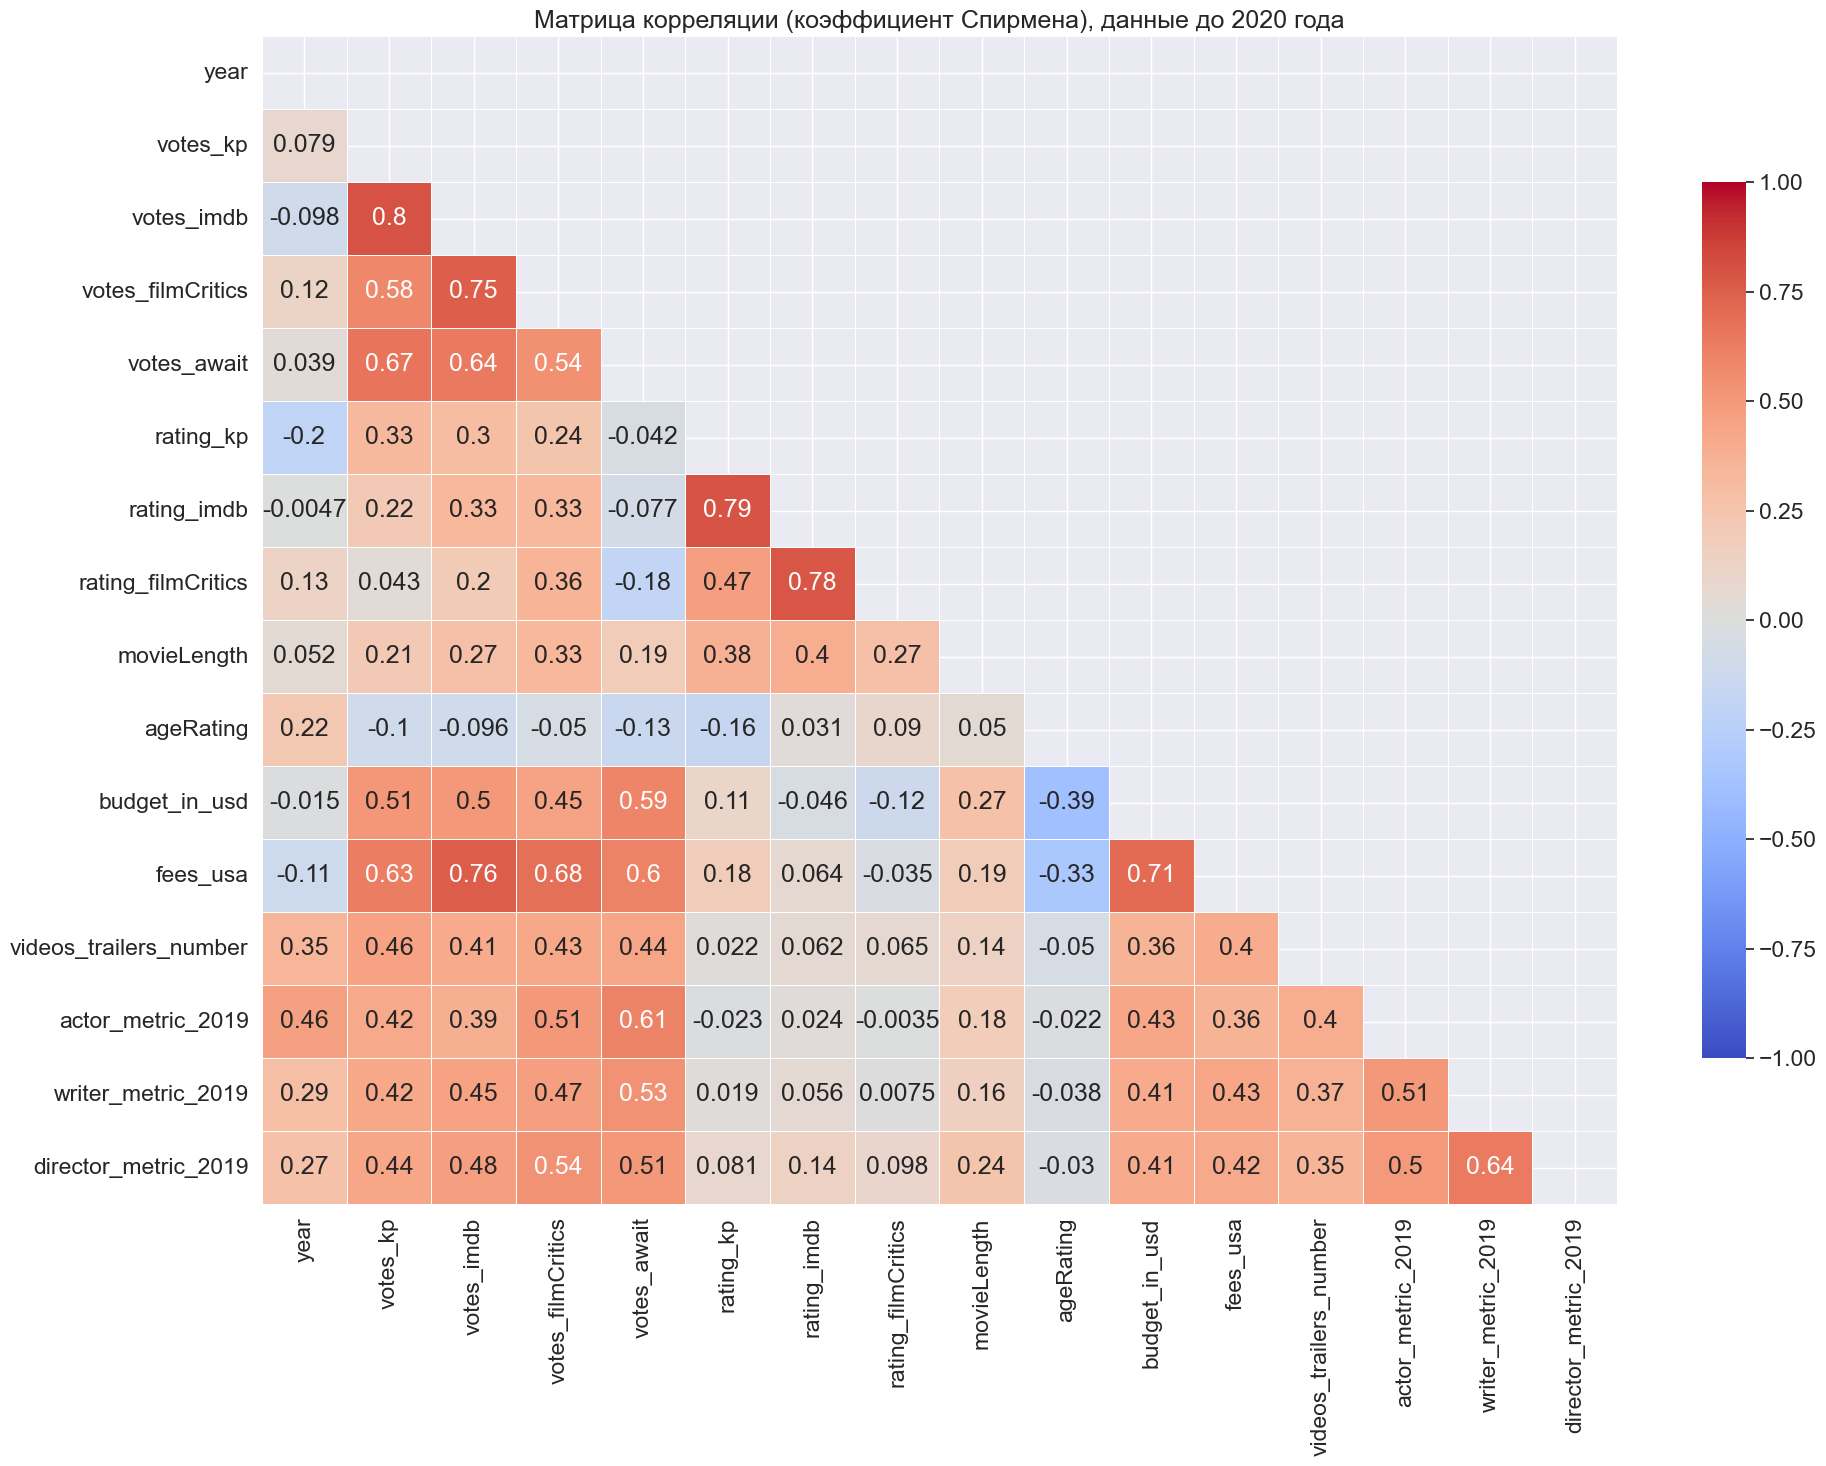

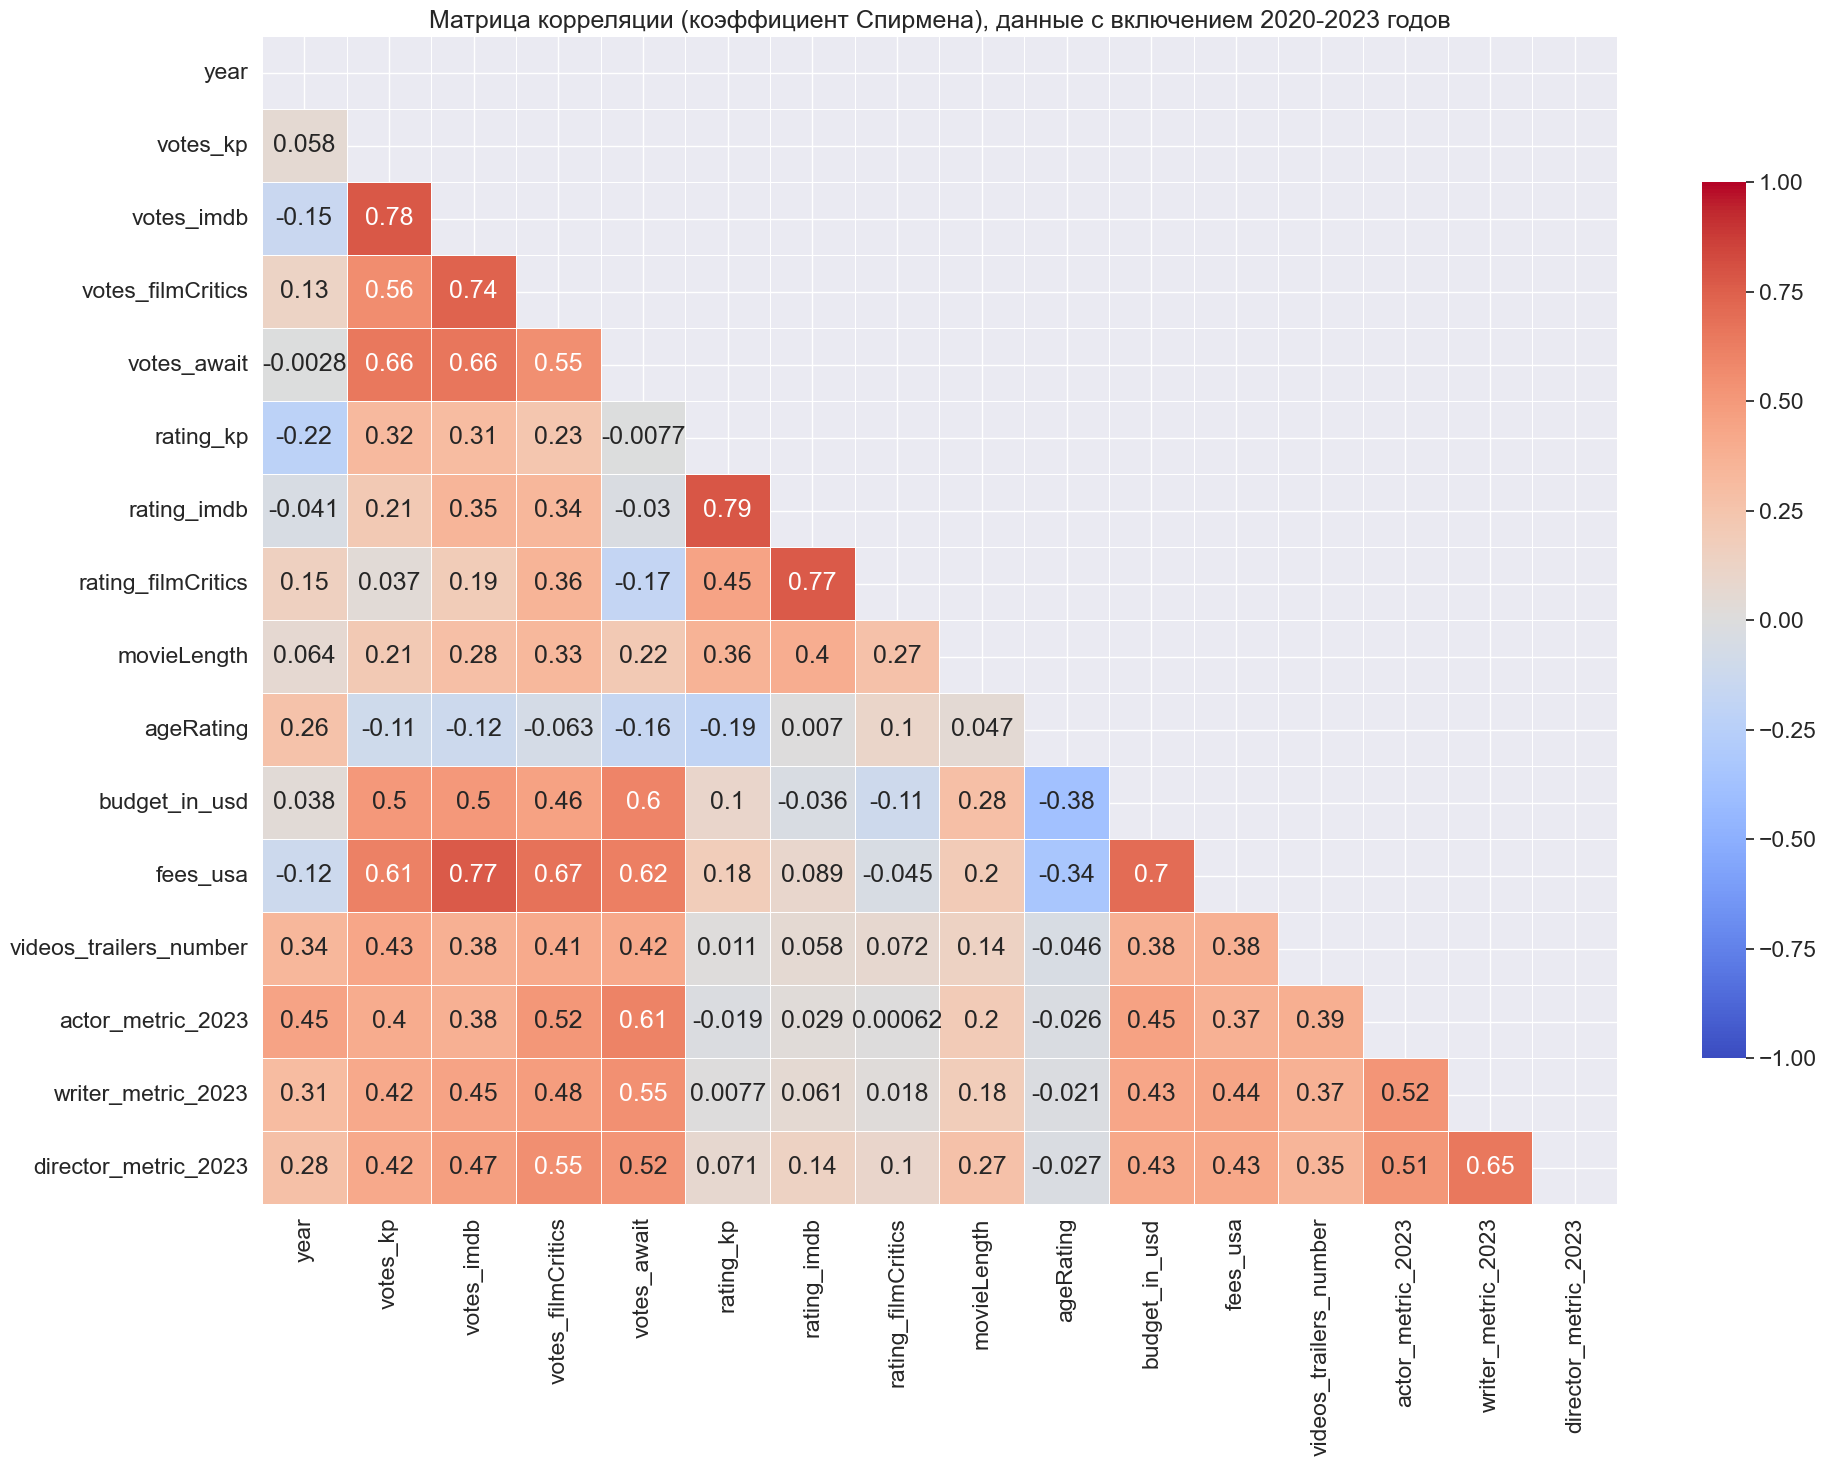

In [47]:
plot_corr(df_main_movies[df_main_movies.year < 2020], features_2019,
          "Матрица корреляции (коэффициент Спирмена), данные до 2020 года")

plot_corr(df_main_movies, features_2023,
          "Матрица корреляции (коэффициент Спирмена), данные с включением 2020-2023 годов")

Некоторые заметные различия в корреляциях между двумя данными:

1. **Год выпуска и другие метрики (изменения после включения 2020-2023 годов)**:
    - Взаимосвязь года выпуска и рейтинга на KP усилилась (с -0.20 до -0.22).
    - Взаимосвязь года выпуска и голосов на IMDb стала более отрицательной (с -0.10 до -0.15).
    - Взаимосвязь года выпуска и возрастного рейтинга усилилась (с 0.22 до 0.26).
    
    
2. **Голоса KP и другие метрики**:
    - Корреляция между голосами на KP и IMDb незначительно уменьшилась (с 0.80 до 0.78).


3. **Рейтинг KP и другие метрики**:
    - Взаимосвязь рейтинга на KP и возрастного рейтинга усилилась (с -0.16 до -0.19).


4. **Сборы в США и другие метрики**:
    - Взаимосвязь сборов в США и возрастного рейтинга усилилась (с -0.33 до -0.34).


5. **Метрики актеров, режиссеров и сценаристов 2019 и 2023 годов**:
    - В большинстве случаев корреляции остались приближенными к предыдущим значениям, что говорит о стабильности этих метрик во времени.
    
**Общий вывод:**

- Многие корреляции остались стабильными или изменились незначительно после включения данных за 2020-2023 годы. Это может говорить о стабильности взаимосвязей между различными метриками во времени.

- Однако некоторые изменения в корреляциях заслуживают внимания. Например, усиление отрицательной взаимосвязи года выпуска и рейтинга на KP может указывать на то, что более новые фильмы в среднем получают более низкий рейтинг на Кинопоиске.

In [48]:
df_main_movies.to_csv(
    'data/movies_main_modified_METRICS_imdb.csv', sep=';', index=False)